In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [4]:
data = pd.read_csv('azd.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

    priceDate itemName         state mandiName  arrivals unitArrivals variety  \
0  2005-04-11   Potato  NCT of Delhi   Azadpur     106.0       Tonnes  F.A.Q.   
1  2005-04-12   Potato  NCT of Delhi   Azadpur    1745.0       Tonnes  F.A.Q.   
2  2005-04-13   Potato  NCT of Delhi   Azadpur    1233.0       Tonnes  F.A.Q.   
3  2005-04-16   Potato  NCT of Delhi   Azadpur    1654.0       Tonnes  F.A.Q.   
4  2005-04-18   Potato  NCT of Delhi   Azadpur      26.0       Tonnes  F.A.Q.   

   minPrice  maxPrice  modalPrice   priceUnit  
0     300.0     663.0       475.0  Rs/Quintal  
1     325.0     688.0       500.0  Rs/Quintal  
2     300.0     688.0       488.0  Rs/Quintal  
3     350.0     650.0       475.0  Rs/Quintal  
4     350.0     650.0       475.0  Rs/Quintal  

 Data Types:
priceDate        object
itemName         object
state            object
mandiName        object
arrivals        float64
unitArrivals     object
variety          object
minPrice        float64
maxPrice        flo

In [5]:
columns_to_drop = ['unitArrivals','itemName','state','mandiName','priceUnit','arrivals']
columns_to_keep =  list(set(data.columns) - set(columns_to_drop))
data = data[columns_to_keep]
print(data.head())



   maxPrice   priceDate  minPrice  modalPrice variety
0     663.0  2005-04-11     300.0       475.0  F.A.Q.
1     688.0  2005-04-12     325.0       500.0  F.A.Q.
2     688.0  2005-04-13     300.0       488.0  F.A.Q.
3     650.0  2005-04-16     350.0       475.0  F.A.Q.
4     650.0  2005-04-18     350.0       475.0  F.A.Q.


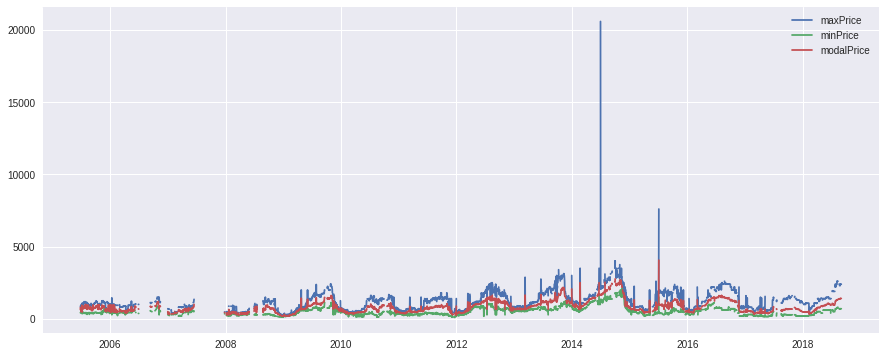

In [6]:
data = data[data.variety == "Potato"]
data = data.drop("variety", axis=1)
data.set_index("priceDate", inplace=True)
grouped = data.groupby(level=0)
data = grouped.mean()
idx = pd.date_range('2005-06-27','2018-08-31')
data.index = pd.DatetimeIndex(data.index)

data = data.reindex(idx)
data.plot()

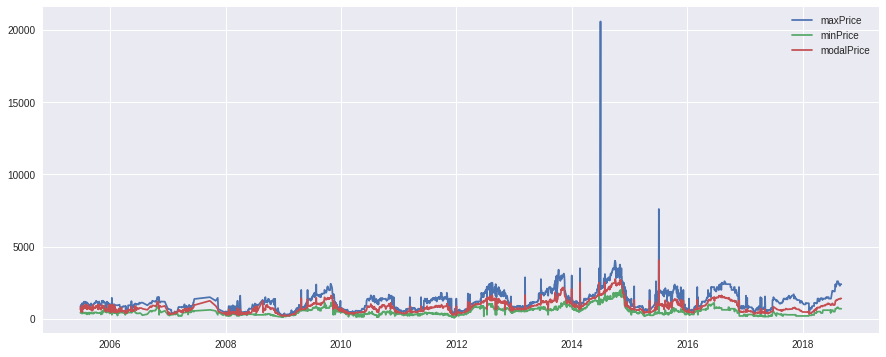

In [7]:
data = data.interpolate()

data.plot() #filled missing data with linear interpolation

In [0]:
#create function to test stationarity of time series
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=365)
    rolstd = pd.rolling_std(timeseries, window=365)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


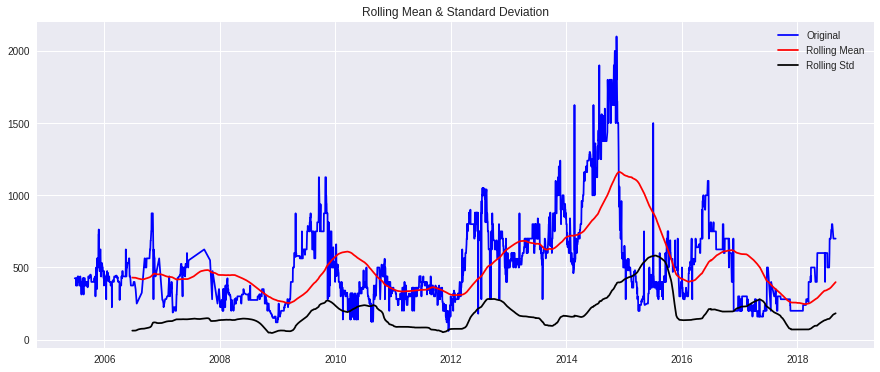

In [9]:
#create time series for minPrice
ts_min = data['minPrice']
ts_min.head()

#testing stationarity of ts_min
test_stationarity(ts_min)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


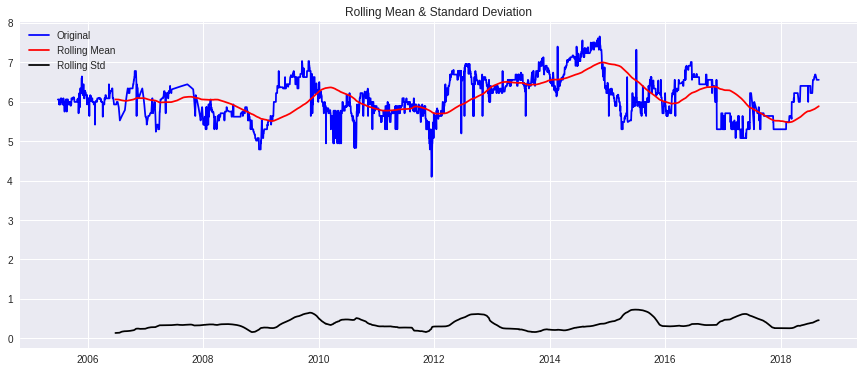

In [10]:
#ts_min is not stationary as rolling mean and rolling std are varying too much although 
#taking log of data and testing stationarity

ts_min_log = np.log(ts_min)
test_stationarity(ts_min_log)

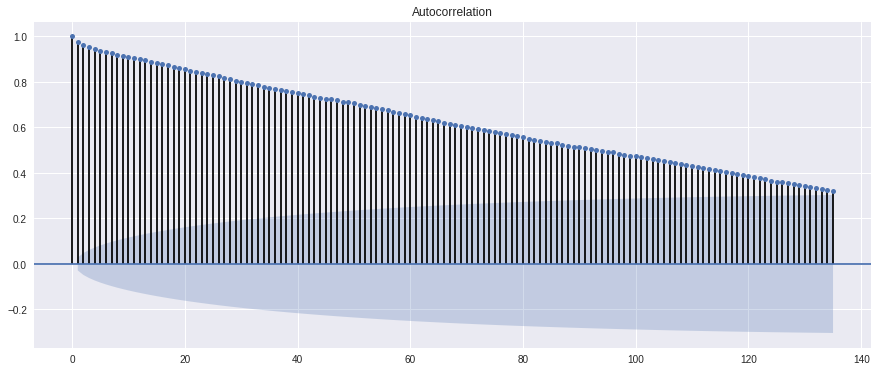

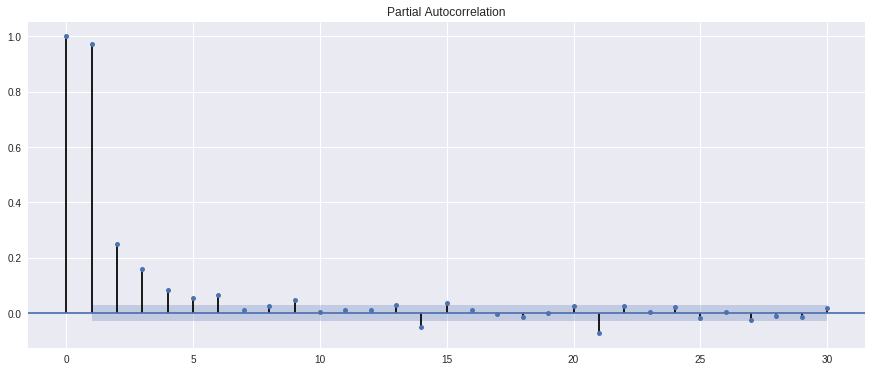

In [11]:
#both mean and Std are varying way less
#plotting Autocorrelation and Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_min_log, lags=135)
plt.show()
plot_pacf(ts_min_log, lags=30)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 60.6863')

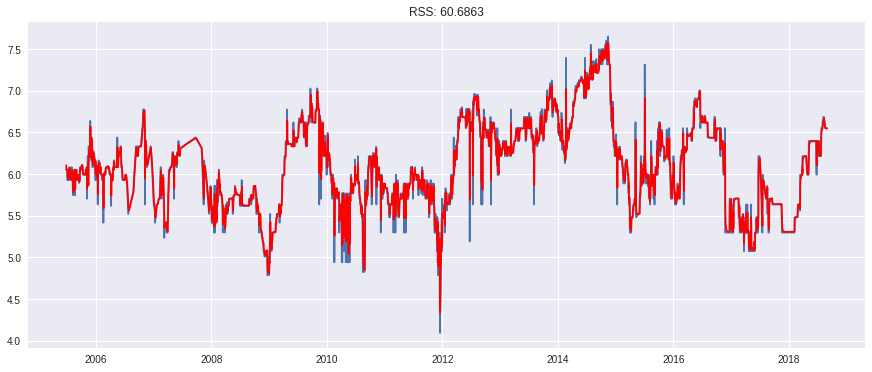

In [25]:
#fitting data on ARIMA model with order of (p,d,q) as (2,0,6) based on acf and pacf functions
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(ts_min_log, order=(6,0,2))  
results_ARIMA_min = model1.fit(disp=-1)  
plt.plot(ts_min_log)
plt.plot(results_ARIMA_min.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_min.fittedvalues-ts_min_log)**2))

In [18]:
#forcasting minPrice for next 30 days
fc_min = results_ARIMA_min.forecast(30)
fc_min = np.exp(fc_min[0])
fc_min


array([696.31108928, 693.82851588, 691.74769882, 689.76156304,
       687.85050046, 686.07634417, 684.29944209, 682.56020456,
       680.83299368, 679.12550518, 677.42931045, 675.74957267,
       674.08281883, 672.43077467, 670.79227781, 669.16783734,
       667.55692601, 665.95965031, 664.37573135, 662.80511979,
       661.24763121, 659.70316455, 658.17157089, 656.65273265,
       655.14651592, 653.65279909, 652.17145557, 650.70236417,
       649.24540284, 647.80045236])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


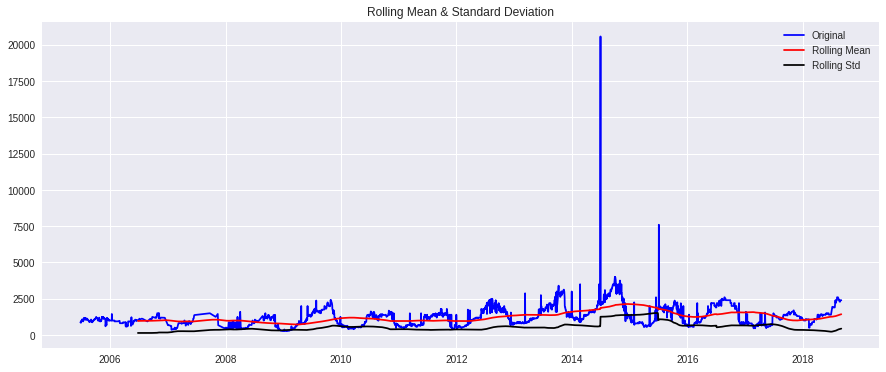

In [19]:
#same procedure for maxPrice
ts_max = data['maxPrice']
test_stationarity(ts_max)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


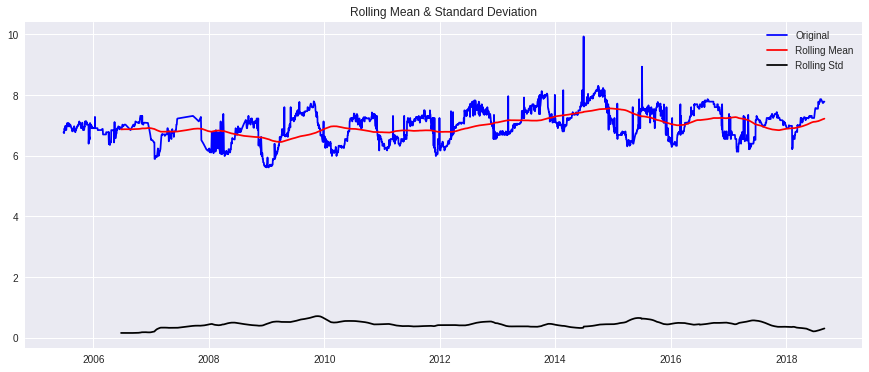

In [20]:
#treating extreme values by taking log transform
ts_max_log = np.log(ts_max)
test_stationarity(ts_max_log)

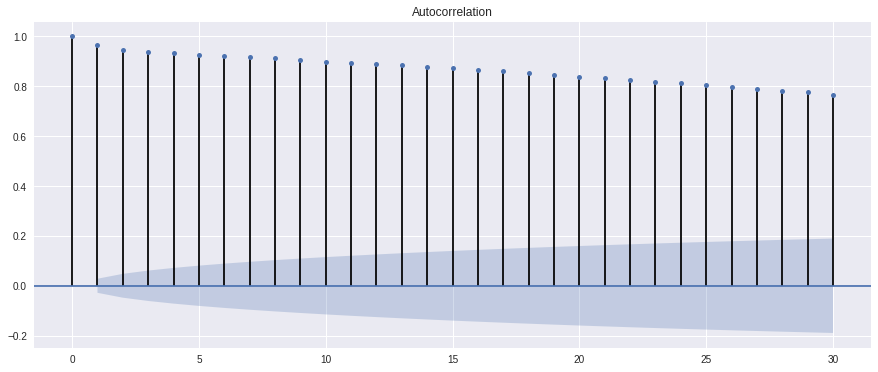

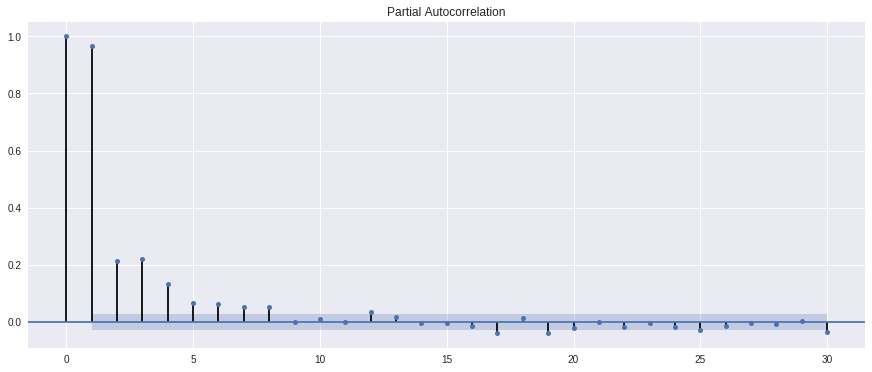

In [22]:
plot_acf(ts_max_log, lags=30)
plt.show()
plot_pacf(ts_max_log, lags=30)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 71.2808')

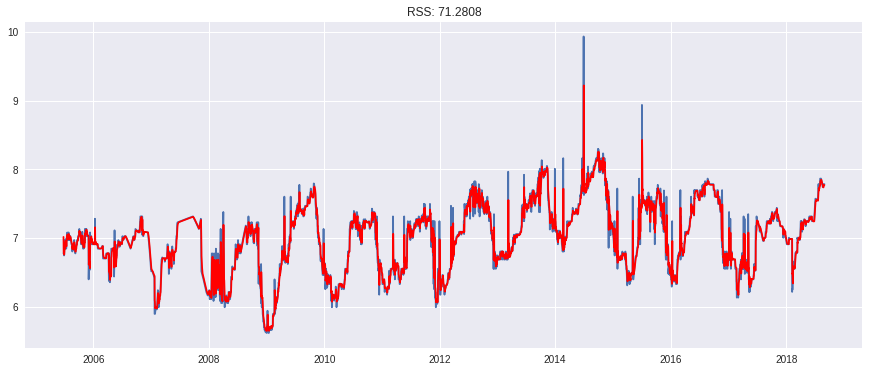

In [26]:
model2 = ARIMA(ts_max_log, order=(8,0,2))  
results_ARIMA_max = model2.fit(disp=-1)  
plt.plot(ts_max_log)
plt.plot(results_ARIMA_max.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_max.fittedvalues-ts_max_log)**2))

In [27]:
#forcasting maxPrice for next 30 days
fc_max = results_ARIMA_max.forecast(30)
fc_max = np.exp(fc_max[0])
fc_max

array([2369.30765943, 2353.88241363, 2342.35144704, 2333.27518984,
       2322.18196712, 2312.95528777, 2303.05342241, 2294.13829251,
       2283.65750835, 2274.19816923, 2264.07935186, 2254.78004127,
       2244.98793713, 2235.8117715 , 2226.33562279, 2217.31612246,
       2208.07472448, 2199.18175324, 2190.15531059, 2181.40649108,
       2172.58356631, 2163.98495133, 2155.35618226, 2146.9120273 ,
       2138.46721093, 2130.17717815, 2121.90765748, 2113.77105719,
       2105.66983025, 2097.68522967])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


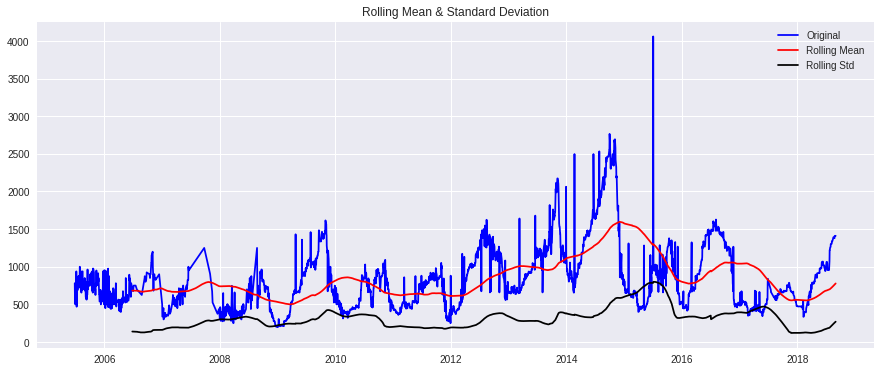

In [28]:
#same procedure for modalPrice
ts_modal = data['modalPrice']
test_stationarity(ts_modal)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


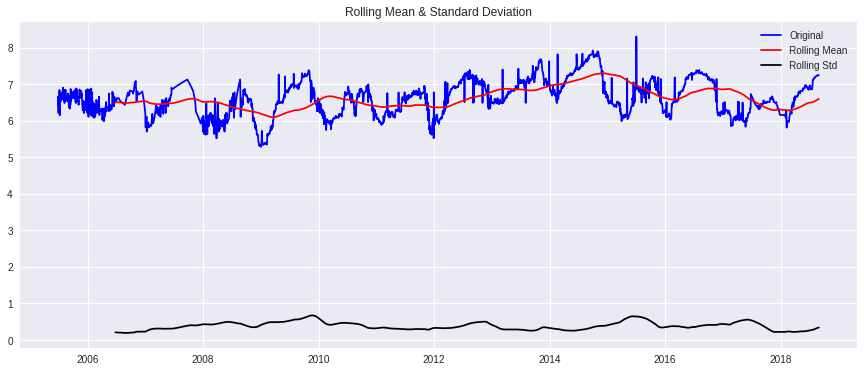

In [29]:
#treating extreme values by taking log transform
ts_modal_log = np.log(ts_modal)
test_stationarity(ts_modal_log)

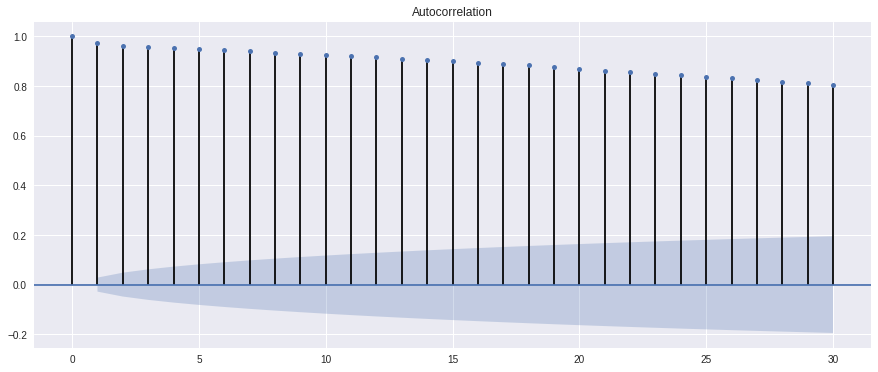

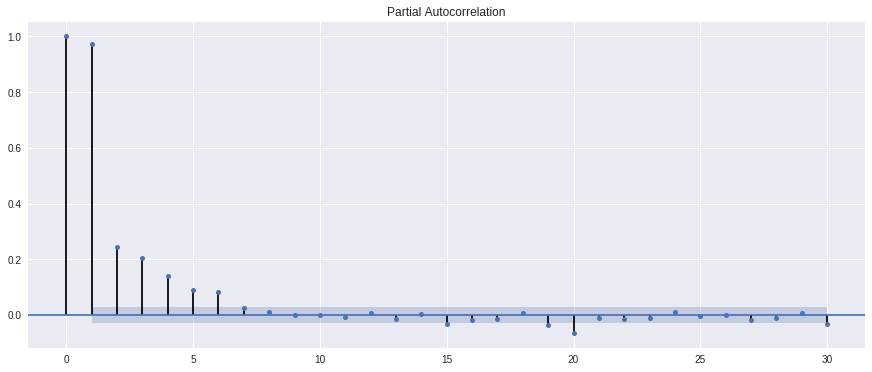

In [30]:
plot_acf(ts_modal_log, lags=30)
plt.show()
plot_pacf(ts_modal_log, lags=30)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 47.1133')

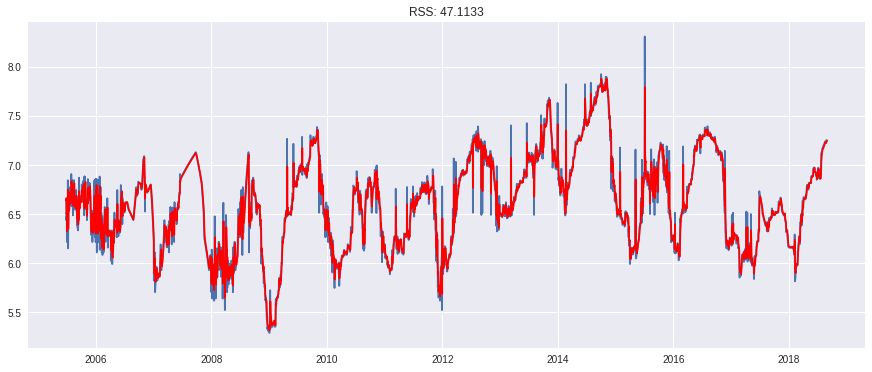

In [31]:
model3 = ARIMA(ts_modal_log, order=(6,0,2))  
results_ARIMA_modal = model3.fit(disp=-1)  
plt.plot(ts_modal_log)
plt.plot(results_ARIMA_modal.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_modal.fittedvalues-ts_modal_log)**2))

In [32]:
#forcasting maxPrice for next 30 days
fc_modal = results_ARIMA_modal.forecast(30)
fc_modal = np.exp(fc_modal[0])
fc_modal

array([1401.30226146, 1395.48203873, 1391.3985819 , 1387.70949092,
       1383.96837589, 1380.32789477, 1376.37779508, 1372.35103487,
       1368.39705278, 1364.52739028, 1360.70801916, 1356.9278491 ,
       1353.16957918, 1349.43034311, 1345.71573778, 1342.03011984,
       1338.37400294, 1334.74671402, 1331.14712523, 1327.57438763,
       1324.02817402, 1320.5084258 , 1317.01504935, 1313.54785744,
       1310.10659796, 1306.69099999, 1303.30080679, 1299.9357833 ,
       1296.59570622, 1293.28035483])

In [0]:
fc_ix = pd.date_range("2018-09-01","2018-09-30")
solution = pd.DataFrame(index = fc_ix)
solution['minPrice'] = fc_min
solution['maxPrice'] = fc_max
solution['modalPrice'] = fc_modal
solution.reset_index(inplace=True)
solution.rename(columns={'index':'priceDate'},inplace=True)
solution.to_csv('forecast.csv')
